# The Inspection Paradox is Everywhere

Allen Downey 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Set the random seed so we get the same results every time
import numpy as np
np.random.seed(17)

In [3]:
import matplotlib.pyplot as plt

# Convenience function for decorating axes in Pyplot.
def decorate(**options):
    """Decorate the current axes."""
    ax = plt.gca()
    ax.set(**options)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.tight_layout()

## Family size

Let's get the data from the online survey.

In [4]:
import pandas as pd

sheet_id = '1SAjOrEd_JC_GhRPG-i1vG1q7DgcoxfN0jWJmSD4LI1A'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv'
df = pd.read_csv(url)
df.columns = ['Timestamp', 'Number of children']
df.head()

,Timestamp,Number of children
0,NaN,NaN
1,NaN,NaN
2,11/1/2019 10:54:05,1.0
3,11/1/2019 10:54:28,4.0
4,11/1/2019 10:54:37,2.0


And pull out the column with the data.

In [5]:
sizes = df['Number of children'].copy()

And plot the distribution of family size.

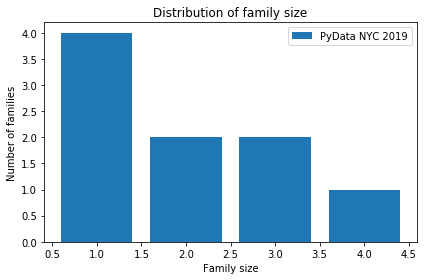

In [6]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(sizes, normalize=False)
pmf.bar(label='PyData NYC 2019')

decorate(xlabel='Family size',
         ylabel='Number of families',
         title='Distribution of family size')

Just in case anyone is messing with us.

In [7]:
sizes[sizes > 20] = np.nan

The mean of the data is meant to estimate the average family size in the U.S.

But does it?

In [8]:
sizes.mean()

2.0

## Class size

Here's the data summarizing the distribution of undergraduate class sizes at Purdue University in 2013-14.

[Class size data originally posted here](https://www.purdue.edu/datadigest/2013-14/InstrStuLIfe/DistUGClasses.html)

[Now archived here](https://web.archive.org/web/20160415011613/https://www.purdue.edu/datadigest/2013-14/InstrStuLIfe/DistUGClasses.html)



In [9]:
sizes = [(1, 1), 
         (2, 9),
         (10, 19),
         (20, 29),
         (30, 39),
         (40, 49),
         (50, 99),
         (100, 300)]
         
counts = [138, 635, 1788, 1979, 796, 354, 487, 333]

I generate a sample from this distribution, assuming a uniform distribution in each range and an upper bound of 300.

In [10]:
def generate_sample(sizes, counts):
    """Generate a sample from a distribution.
    
    sizes: sequence of (low, high) pairs
    counts: sequence of integers
    
    returns: NumPy array
    """
    t = []
    for (low, high), count in zip(sizes, counts):
        print(low, high, count)
        sample = np.random.randint(low, high+1, count)
        t.extend(sample)
    return np.array(t)

The "unbiased" sample is as seen by the college, with each class equally likely to be in the sample.

In [11]:
unbiased = generate_sample(sizes, counts)

1 1 138
2 9 635
10 19 1788
20 29 1979
30 39 796
40 49 354
50 99 487
100 300 333


To generate a biased sample, we use the values themselves as weights and resample with replacement.

In [12]:
def resample_weighted(sample, weights):
    """Generate a biased sample.
    
    sample: NumPy array
    weights: NumPy array
    
    returns: NumPy array
    """
    n = len(sample)
    p = weights / np.sum(weights)
    return np.random.choice(sample, n, p=p)

In [13]:
biased = resample_weighted(unbiased, unbiased)

To plot the distribution, I use KDE to estimate the density function, then evaluate it over the given sequence of `xs`.

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def kdeplot(sample, xs, label=None, **options):
    """Use KDE to plot the density function.
    
    sample: NumPy array
    xs: NumPy array
    label: string
    """
    density = gaussian_kde(sample, **options).evaluate(xs)
    plt.plot(xs, density, label=label)
    decorate(ylabel='Relative likelihood')

The following plot shows the distribution of class size as seen by the Dean, and as seen by a sample of students.

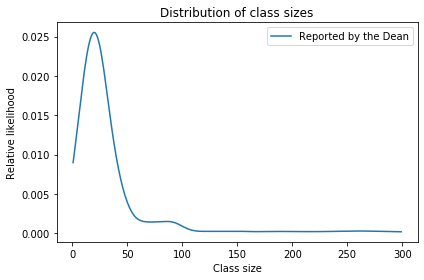

In [15]:
xs = np.arange(1, 300)
kdeplot(unbiased, xs, 'Reported by the Dean')

decorate(xlabel='Class size',
         title='Distribution of class sizes')

plt.savefig('class_size0.png', dpi=150)

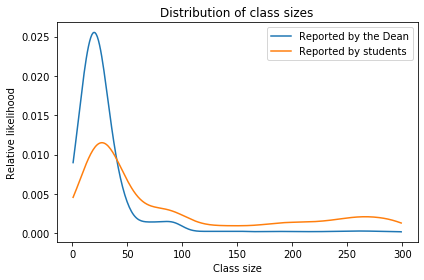

In [16]:
xs = np.arange(1, 300)
kdeplot(unbiased, xs, 'Reported by the Dean')
kdeplot(biased, xs, 'Reported by students')

decorate(xlabel='Class size',
         title='Distribution of class sizes')

plt.savefig('class_size1.png', dpi=150)

Here are the means of the unbiased and biased distributions.

In [17]:
np.mean(unbiased)

34.611827956989245

In [18]:
np.mean(biased)

92.59815668202765

In [19]:
sample = np.random.choice(biased, 500)

In [20]:
reweighted = resample_weighted(sample, 1/sample)

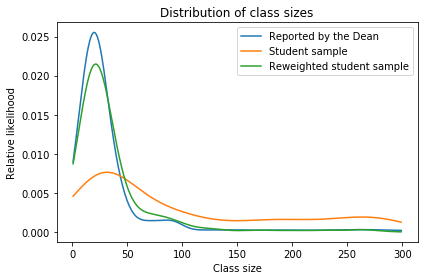

In [21]:
xs = np.arange(1, 300)
kdeplot(unbiased, xs, 'Reported by the Dean')
kdeplot(sample, xs, 'Student sample')
kdeplot(reweighted, xs, 'Reweighted student sample')

decorate(xlabel='Class size',
         title='Distribution of class sizes')

plt.savefig('class_size3.png', dpi=150)

In [22]:
from empiricaldist import Cdf

def cdfplot(sample, xs, label=None, **options):
    """Plot the CDF of the sample.
    
    sample: NumPy array
    xs: NumPy array (ignored)
    label: string
    """
    cdf = Cdf.from_seq(sample, **options)
    cdf.plot(label=label)
    decorate(ylabel='CDF')

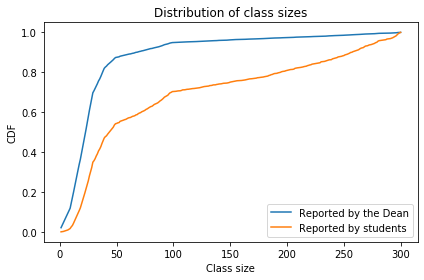

In [23]:
xs = np.arange(1, 300)
cdfplot(unbiased, xs, 'Reported by the Dean')
cdfplot(biased, xs, 'Reported by students')

decorate(xlabel='Class size',
         title='Distribution of class sizes')

plt.savefig('class_size2.png', dpi=150)

## Red Line

Here are times between trains in seconds.

In [24]:
unbiased = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

Here's the same data in minutes.

In [25]:
unbiased = np.array(unbiased) / 60

We can use the same function to generate a biased sample.

In [26]:
biased = resample_weighted(unbiased, unbiased)

And plot the results.

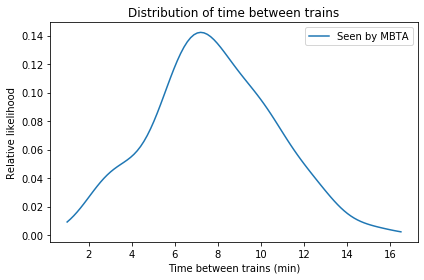

In [27]:
xs = np.linspace(1, 16.5, 101)
kdeplot(unbiased, xs, 'Seen by MBTA')

decorate(xlabel='Time between trains (min)',
         title='Distribution of time between trains')

plt.savefig('red_line0.png', dpi=150)

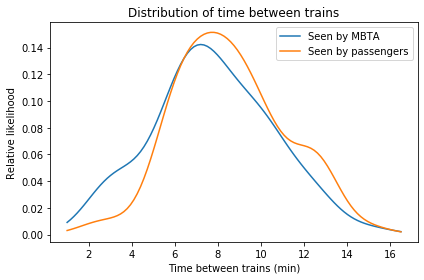

In [28]:
xs = np.linspace(1, 16.5, 101)
kdeplot(unbiased, xs, 'Seen by MBTA')
kdeplot(biased, xs, 'Seen by passengers')

decorate(xlabel='Time between trains (min)',
         title='Distribution of time between trains')

plt.savefig('red_line1.png', dpi=150)

Here are the means of the distributions and the percentage difference.

In [29]:
np.mean(biased), np.mean(unbiased)

(8.570714285714285, 7.7680952380952375)

In [30]:
(np.mean(biased) - np.mean(unbiased)) /  np.mean(unbiased) * 100

10.332250352479615

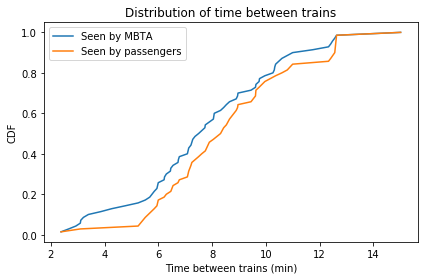

In [31]:
xs = np.linspace(1, 16.5, 101)
cdfplot(unbiased, xs, 'Seen by MBTA')
cdfplot(biased, xs, 'Seen by passengers')

decorate(xlabel='Time between trains (min)',
         title='Distribution of time between trains')

plt.savefig('red_line2.png', dpi=150)

In [32]:
unbiased_pmf = Pmf.from_seq(unbiased)

In [33]:
biased_pmf = Pmf(unbiased_pmf * unbiased_pmf.qs)
biased_pmf.normalize()

7.768095238095237

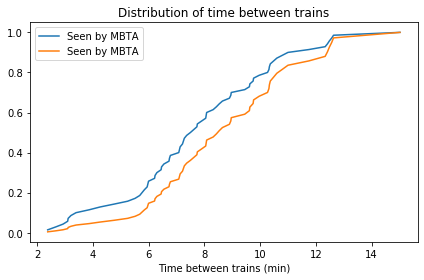

In [34]:
unbiased_pmf.make_cdf().plot(label='Seen by MBTA')
biased_pmf.make_cdf().plot(label='Seen by MBTA')

decorate(xlabel='Time between trains (min)',
         title='Distribution of time between trains')

plt.savefig('red_line2.png', dpi=150)

## Social network

Read the Facebook data from the [Stanford Network Analysis Project (SNAP)](http://snap.stanford.edu/).

In [35]:
# download the Facebook data from SNAP
import os

if not os.path.exists('facebook_combined.txt.gz'):
    !wget https://snap.stanford.edu/data/facebook_combined.txt.gz

Parse it with Numpy and make a NetworkX graph.

In [36]:
import networkx as nx

def read_graph(filename):
    """Read a graph from a file.
    
    filename: string
    
    return: Graph
    """
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [37]:
fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

The unbiased sample is the number of friends for each user, which is the degree of each node.

In [38]:
unbiased = [fb.degree(node) for node in fb]
len(unbiased)

4039

In [39]:
np.max(unbiased)

1045

We can use the same function to generate a biased sample.

In [40]:
biased = resample_weighted(unbiased, unbiased)

And generate the plot.

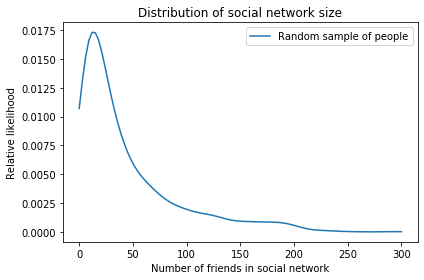

In [41]:
xs = np.linspace(0, 300, 101)
kdeplot(unbiased, xs, 'Random sample of people')

decorate(xlabel='Number of friends in social network',
         title='Distribution of social network size')

plt.savefig('social0.png', dpi=150)

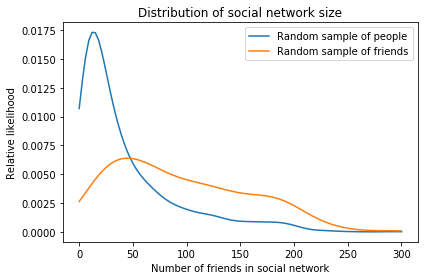

In [42]:
xs = np.linspace(0, 300, 101)
kdeplot(unbiased, xs, 'Random sample of people')
kdeplot(biased, xs, 'Random sample of friends')

decorate(xlabel='Number of friends in social network',
         title='Distribution of social network size')

plt.savefig('social1.png', dpi=150)

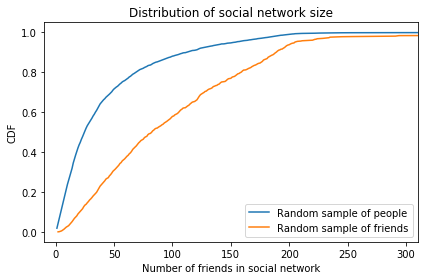

In [43]:
xs = np.linspace(0, 300, 101)
cdfplot(unbiased, xs, 'Random sample of people')
cdfplot(biased, xs, 'Random sample of friends')

decorate(xlabel='Number of friends in social network',
         title='Distribution of social network size',
         xlim=[-10, 310])

plt.savefig('social2.png', dpi=150)

Here are the means of the distributions.

In [44]:
np.mean(biased), np.mean(unbiased)

(105.0562020302055, 43.69101262688784)

And the probability that the friend of a user has more friends than the user.

In [45]:
np.mean(biased > unbiased)

0.7680118841297351

## Relay race

Let's get the results from the 2010 James Joyce Ramble 10K, where I ran my personal record time.

In [46]:
if not os.path.exists('Apr25_27thAn_set1.shtml'):
    !wget http://coolrunning.com/results/10/ma/Apr25_27thAn_set1.shtml

In [47]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(open('Apr25_27thAn_set1.shtml'), 'html.parser')

In [48]:
import pandas as pd
speeds = pd.Series([])

In [49]:
table = soup.find('pre')
for line in table.text.split('\n'):
    t = line.split()
    if len(t) in [13, 14]:
        place, place_in_div, div, gun, net, pace = t[0:6]
        place = int(place)
        m, s = [int(x) for x in pace.split(':')]
        secs = m*60 + s
        mph  = 1 / secs * 60 * 60
        speeds[place] = mph

In [50]:
speeds.head()

1    12.121212
2    11.764706
3    11.726384
4    11.464968
5    11.320755
dtype: float64

In [51]:
speeds.tail()

1629    3.383459
1630    3.278689
1631    3.278689
1632    3.225806
1633    3.061224
dtype: float64

In [52]:
speeds[97]

8.716707021791768

In this case, the weights are related to the difference between each element of the sample and the hypothetical speed of the observer.

In [53]:
unbiased = speeds.values

In [54]:
weights = np.abs(unbiased - 7)
biased = resample_weighted(unbiased, weights)

And here's the plot.

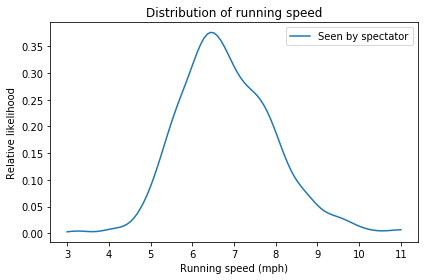

In [55]:
xs = np.linspace(3, 11, 101)
kdeplot(unbiased, xs, 'Seen by spectator')

decorate(xlabel='Running speed (mph)',
         title='Distribution of running speed')

plt.savefig('relay0.png', dpi=150)

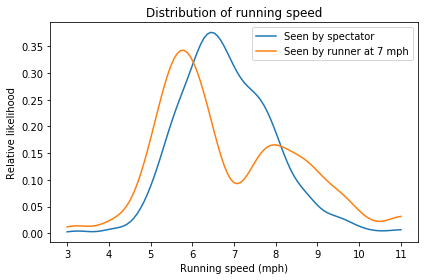

In [56]:
xs = np.linspace(3, 11, 101)
kdeplot(unbiased, xs, 'Seen by spectator')
kdeplot(biased, xs, 'Seen by runner at 7 mph', bw_method=0.2)

decorate(xlabel='Running speed (mph)',
         title='Distribution of running speed')

plt.savefig('relay1.png', dpi=150)

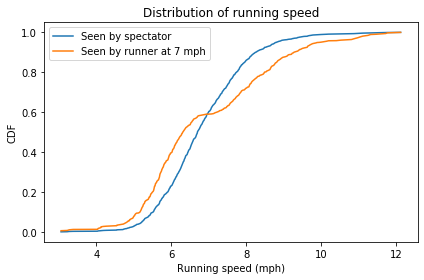

In [57]:
xs = np.linspace(3, 11, 101)
cdfplot(unbiased, xs, 'Seen by spectator')
cdfplot(biased, xs, 'Seen by runner at 7 mph')

decorate(xlabel='Running speed (mph)',
         title='Distribution of running speed')

plt.savefig('relay2.png', dpi=150)

## Prison sentences

First we read the [data from the Bureau of Prisons web page](https://www.bop.gov/about/statistics/statistics_inmate_sentences.jsp).

In [58]:
if not os.path.exists('BOP Statistics_ Sentences Imposed.html'):
    !wget https://raw.githubusercontent.com/AllenDowney/InspectionParadox/master/BOP%20Statistics_%20Sentences%20Imposed.html

In [59]:
tables = pd.read_html('BOP Statistics_ Sentences Imposed.html')
df = tables[0]
df

,Sentence,# of Inmates,% of Inmates
0,0 to 1 year*,5155,2.3 %
1,> 1 year to < 3 years**,18619,11.3%
2,3 years to < 5 years,17897,10.9%
3,5 years to < 10 years,41887,25.4%
4,10 years to < 15 years,34995,21.3%
5,15 years to < 20 years,18674,11.3%
6,20 years or more but < Life,22738,13.8%
7,Life,4600,2.8%


Here are the low and high sentences for each range.  I assume that the minimum sentence is about a week, that sentences "less than life" are 40 years, and that a life sentence is between 40 and 60 years.

In [60]:
sentences = [(0.02, 1),
             (1, 3),
             (3, 5),
             (5, 10),
             (10, 15),
             (15, 20),
             (20, 40),
             (40, 60)]

We can get the counts from the table.

In [61]:
counts = df['# of Inmates']

Here's a different version of `generate_sample` for a continuous quantity.

In [62]:
def generate_sample(sizes, counts):
    """Generate a sample from a distribution.
    
    sizes: sequence of (low, high) pairs
    counts: sequence of integers
    
    returns: NumPy array
    """
    t = []
    for (low, high), count in zip(sizes, counts):
        print(count, low, high)
        sample = np.random.uniform(low, high, count)
        t.extend(sample)
    return np.array(t)

In this case, the data are biased.

In [63]:
biased = generate_sample(sentences, counts)

5155 0.02 1
18619 1 3
17897 3 5
41887 5 10
34995 10 15
18674 15 20
22738 20 40
4600 40 60


So we have to unbias them with weights inversely proportional to the values.

Prisoners in federal prison typically serve 85% of their nominal sentence.  

We can take that into account in the weights.

In [64]:
weights = 1 / (0.85 * np.array(biased))

Here's the unbiased sample.

In [65]:
unbiased = resample_weighted(biased, weights)

And the plotted distributions.

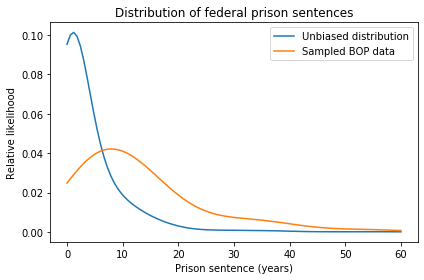

In [66]:
xs = np.linspace(0, 60, 101)
kdeplot(unbiased, xs, 'Unbiased distribution', bw_method=0.5)
kdeplot(biased, xs, 'Sampled BOP data', bw_method=0.5)

decorate(xlabel='Prison sentence (years)',
         title='Distribution of federal prison sentences')

plt.savefig('orange.png', dpi=150)

/home/downey/anaconda3/envs/InspectionParadox/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/home/downey/anaconda3/envs/InspectionParadox/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
/home/downey/anaconda3/envs/InspectionParadox/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


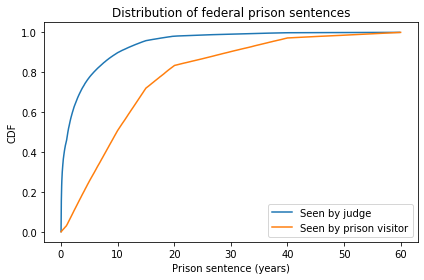

In [67]:
xs = np.linspace(0, 60, 101)
cdfplot(unbiased, xs, 'Seen by judge')
cdfplot(biased, xs, 'Seen by prison visitor')

decorate(xlabel='Prison sentence (years)',
         title='Distribution of federal prison sentences')

plt.savefig('orange2.png', dpi=150)

We can also compute the distribution of sentences as seen by someone at the prison for 13 months.

In [68]:
x = 0.85 * unbiased
t = 13 / 12

weights = x + t

Here's the sample.

In [69]:
kerman = resample_weighted(unbiased, weights)

And here's what it looks like.

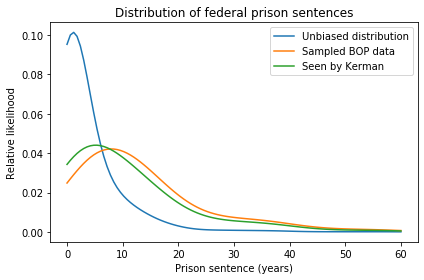

In [70]:
xs = np.linspace(0, 60, 101)
kdeplot(unbiased, xs, 'Unbiased distribution', bw_method=0.5)
kdeplot(biased, xs, 'Sampled BOP data', bw_method=0.5)
kdeplot(kerman, xs, 'Seen by Kerman', bw_method=0.5)

decorate(xlabel='Prison sentence (years)',
         title='Distribution of federal prison sentences')

plt.savefig('orange3.png', dpi=150)

/home/downey/anaconda3/envs/InspectionParadox/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/home/downey/anaconda3/envs/InspectionParadox/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if __name__ == '__main__':


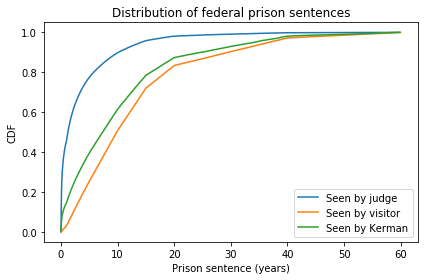

In [71]:
xs = np.linspace(0, 60, 101)
cdfplot(unbiased, xs, 'Seen by judge')
cdfplot(biased, xs, 'Seen by visitor')
cdfplot(kerman, xs, 'Seen by Kerman')

decorate(xlabel='Prison sentence (years)',
         title='Distribution of federal prison sentences')

plt.savefig('orange4.png', dpi=150)

In the unbiased distribution, almost half of prisoners serve less than one year.

In [72]:
np.mean(unbiased<1)

0.4592227995017166

But if we sample the prison population, barely 3% are short timers.

In [73]:
np.mean(biased<1)

0.0313250083553611

Here are the means of the distributions.

In [74]:
np.mean(unbiased)

3.5009381258407184

In [75]:
np.mean(biased)

12.771052476272239

In [76]:
np.mean(kerman)

10.211335148729502

## Biasing with PMFs

Instead of resampling, we can compute the biased PMF directly by multiplying the probabilities by the values.

In [97]:
sample = [0,0,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,5]

In [98]:
pmf = Pmf.from_seq(sample)
pmf.qs

array([0, 1, 2, 3, 4, 5])

In [99]:
pmf.ps

array([0.0952381 , 0.14285714, 0.23809524, 0.33333333, 0.14285714,
       0.04761905])

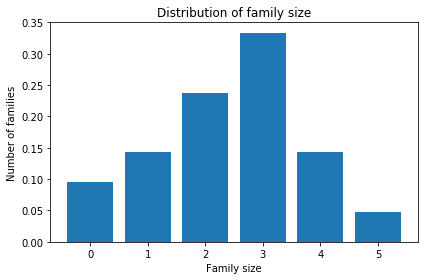

In [100]:
pmf.bar()

decorate(xlabel='Family size',
         ylabel='Number of families',
         title='Distribution of family size')

In [101]:
biased_pmf = Pmf(pmf * pmf.qs)
biased_pmf.normalize()

2.428571428571429

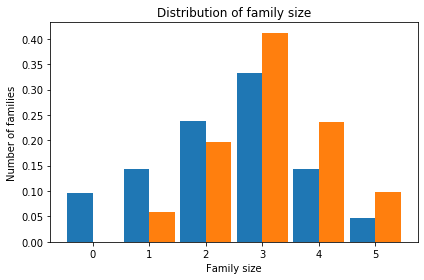

In [102]:
pmf.bar(width=-0.45, align='edge')
biased_pmf.bar(width=0.45, align='edge')

decorate(xlabel='Family size',
         ylabel='Number of families',
         title='Distribution of family size')

## The dartboard problem

In [83]:
from matplotlib.patches import Circle

def draw_dartboard():
    ax = plt.gca()

    c1 = Circle((0, 0), 170, color='C3', alpha=0.3)
    c2 = Circle((0, 0), 160, color='white')
    c3 = Circle((0, 0), 107, color='C3', alpha=0.3)
    c4 = Circle((0, 0), 97, color='white')
    c5 = Circle((0, 0), 16, color='C3', alpha=0.3)
    c6 = Circle((0, 0), 6, color='white')
    for circle in [c1, c2, c3, c4, c5, c6]:
        ax.add_patch(circle)
    plt.axis('equal')
    

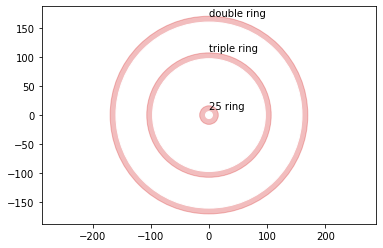

In [84]:
draw_dartboard()
plt.text(0, 10, '25 ring')
plt.text(0, 110, 'triple ring')
plt.text(0, 170, 'double ring')

plt.savefig('darts0.png', dpi=150)

In [85]:
sigma = 50
n = 100
error_x = np.random.normal(0, sigma, size=(n))
error_y = np.random.normal(0, sigma, size=(n))

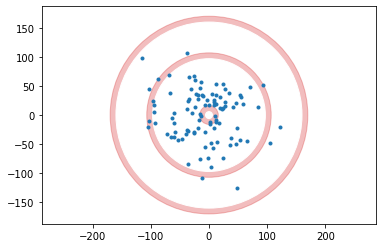

In [86]:
draw_dartboard()
plt.plot(error_x, error_y, '.')
plt.savefig('darts1.png', dpi=150)

In [87]:
sigma = 50
n = 10000
error_x = np.random.normal(0, sigma, size=(n))
error_y = np.random.normal(0, sigma, size=(n))

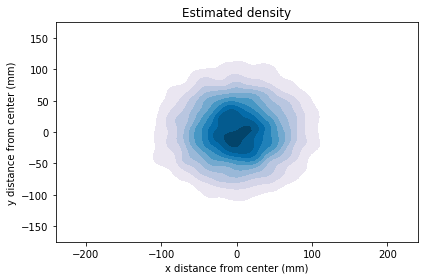

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl

ax = sns.kdeplot(error_x, error_y, shade=True, cmap="PuBu")
ax.collections[0].set_alpha(0)
plt.axis([-240, 240, -175, 175])

decorate(xlabel='x distance from center (mm)',
         ylabel='y distance from center (mm)',
         title='Estimated density')


plt.savefig('darts2.png', dpi=150)

In [89]:
rs = np.hypot(error_x, error_y)

In [90]:
np.random.seed(18)
sigma = 50
n = 10000
error_x = np.random.normal(0, sigma, size=(n))
error_y = np.random.normal(0, sigma, size=(n))

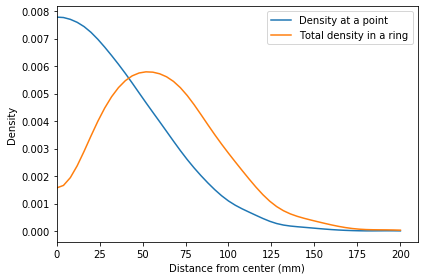

In [91]:
xs = np.linspace(-200, 200, 101)

#ys = np.exp(-(xs/sigma)**2/2)
#pmf = Pmf(ys, index=xs)
#pmf.normalize()
#pmf.plot(color='gray')

unbiased = error_x
biased = resample_weighted(unbiased, np.abs(unbiased))

kdeplot(unbiased, xs, 'Density at a point')
kdeplot(biased, xs, 'Total density in a ring')
#kdeplot(rs, xs, 'Total density in a ring')

decorate(xlabel='Distance from center (mm)',
         ylabel='Density',
         xlim=[0, 210])

plt.savefig('darts3.png', dpi=150)

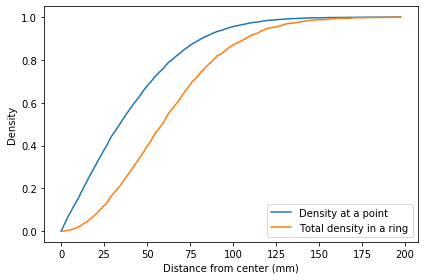

In [92]:
xs = np.linspace(0, 200, 101)
unbiased = np.abs(error_x)
biased = resample_weighted(unbiased, unbiased)

cdfplot(unbiased, xs, 'Density at a point')
cdfplot(biased, xs, 'Total density in a ring')

decorate(xlabel='Distance from center (mm)',
         ylabel='Density')

plt.savefig('darts4.png', dpi=150)

In [93]:
triple = (biased > 97) & (biased < 107)
triple.mean() * 100

4.51

In [94]:
ring25 = (biased > 6) & (biased < 16)
ring25.mean() * 100

4.38

In [95]:
double = (biased > 160) & (biased < 170)
double.mean() * 100

0.33

In [96]:
bull = (biased < 6)
bull.mean() * 100

0.6799999999999999